In [ ]:
!pip install xgboost catboost lightgbm 

## Libraries import

In [66]:
import numpy as np
import pandas as pd
from joblib import dump
import json
from pathlib import Path
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import (
                            mean_absolute_error, 
                            make_scorer, 
                            root_mean_squared_error,
                            r2_score,
                            mean_squared_error
                        )

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import seaborn as sns 
import matplotlib.pyplot as plt

In [28]:
# Optional models – import lazily so the script still runs if libs are missing
OPTIONAL_MODELS = {}
try:
    from catboost import CatBoostRegressor

    OPTIONAL_MODELS["CatBoost"] = CatBoostRegressor(silent=True, random_state=42)
except ImportError:
    pass

try:
    from lightgbm import LGBMRegressor

    OPTIONAL_MODELS["LightGBM"] = LGBMRegressor(random_state=42)
except ImportError:
    pass

try:
    from xgboost import XGBRegressor

    OPTIONAL_MODELS["XGBoost"] = XGBRegressor(objective="reg:squarederror", random_state=42)
except ImportError:
    pass

In [29]:
OPTIONAL_MODELS

{'CatBoost': <catboost.core.CatBoostRegressor at 0x163151d90>,
 'LightGBM': LGBMRegressor(random_state=42),
 'XGBoost': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)}

## Data Loading and Exploration

In [30]:
df = pd.read_csv("vehicle_comparison_dataset_030417.csv")

In [31]:
df.head(10)

,vehicle_type,energy_consumption,co2_emissions_g_per_km,maintenance_cost_annual,cost_per_km,energy_storage_capacity,mileage_km,acceleration_0_100_kph_sec,torque_Nm,lifespan_years
0,EV,13.80,2.68,51768.21,0.14,80.72,138080.30,5.19,328.70,14.33
1,EV,15.58,6.33,44111.33,0.15,48.22,237818.10,6.09,255.42,11.31
2,EV,18.01,3.63,48772.91,0.14,67.79,126086.59,4.60,311.03,10.64
3,EV,13.70,-0.85,39148.49,0.10,67.86,135491.49,7.07,266.63,9.26
4,EV,10.84,-0.66,46485.86,0.13,79.55,126796.32,7.46,263.66,14.83
5,ICE,8.14,137.19,72144.44,0.26,61.84,203733.46,9.00,172.70,8.73
6,EV,19.24,-9.97,35488.24,0.14,72.10,135997.24,8.64,352.84,8.24
7,ICE,5.85,193.10,93416.88,0.38,40.32,128202.72,8.79,156.09,8.33
8,ICE,6.21,153.00,92269.88,0.32,53.41,197395.72,8.55,258.48,10.02
9,ICE,10.51,176.45,102408.92,0.35,42.52,151995.30,10.71,211.59,7.98


In [32]:
df.shape

(2000, 10)

### Plots

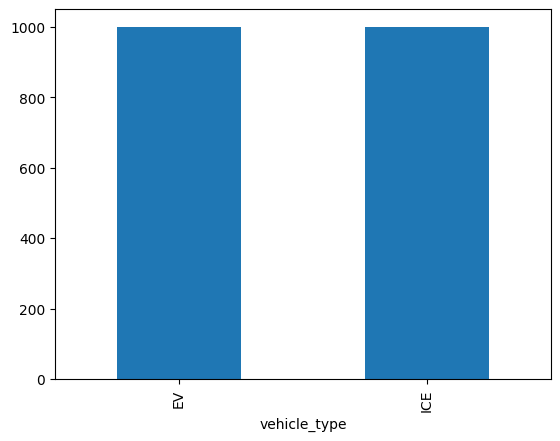

In [33]:
df.vehicle_type.value_counts()
df.vehicle_type.value_counts().plot(kind="bar")
plt.show()

In [34]:
df.isna().sum()

vehicle_type                  0
energy_consumption            0
co2_emissions_g_per_km        0
maintenance_cost_annual       0
cost_per_km                   0
energy_storage_capacity       0
mileage_km                    0
acceleration_0_100_kph_sec    0
torque_Nm                     0
lifespan_years                0
dtype: int64

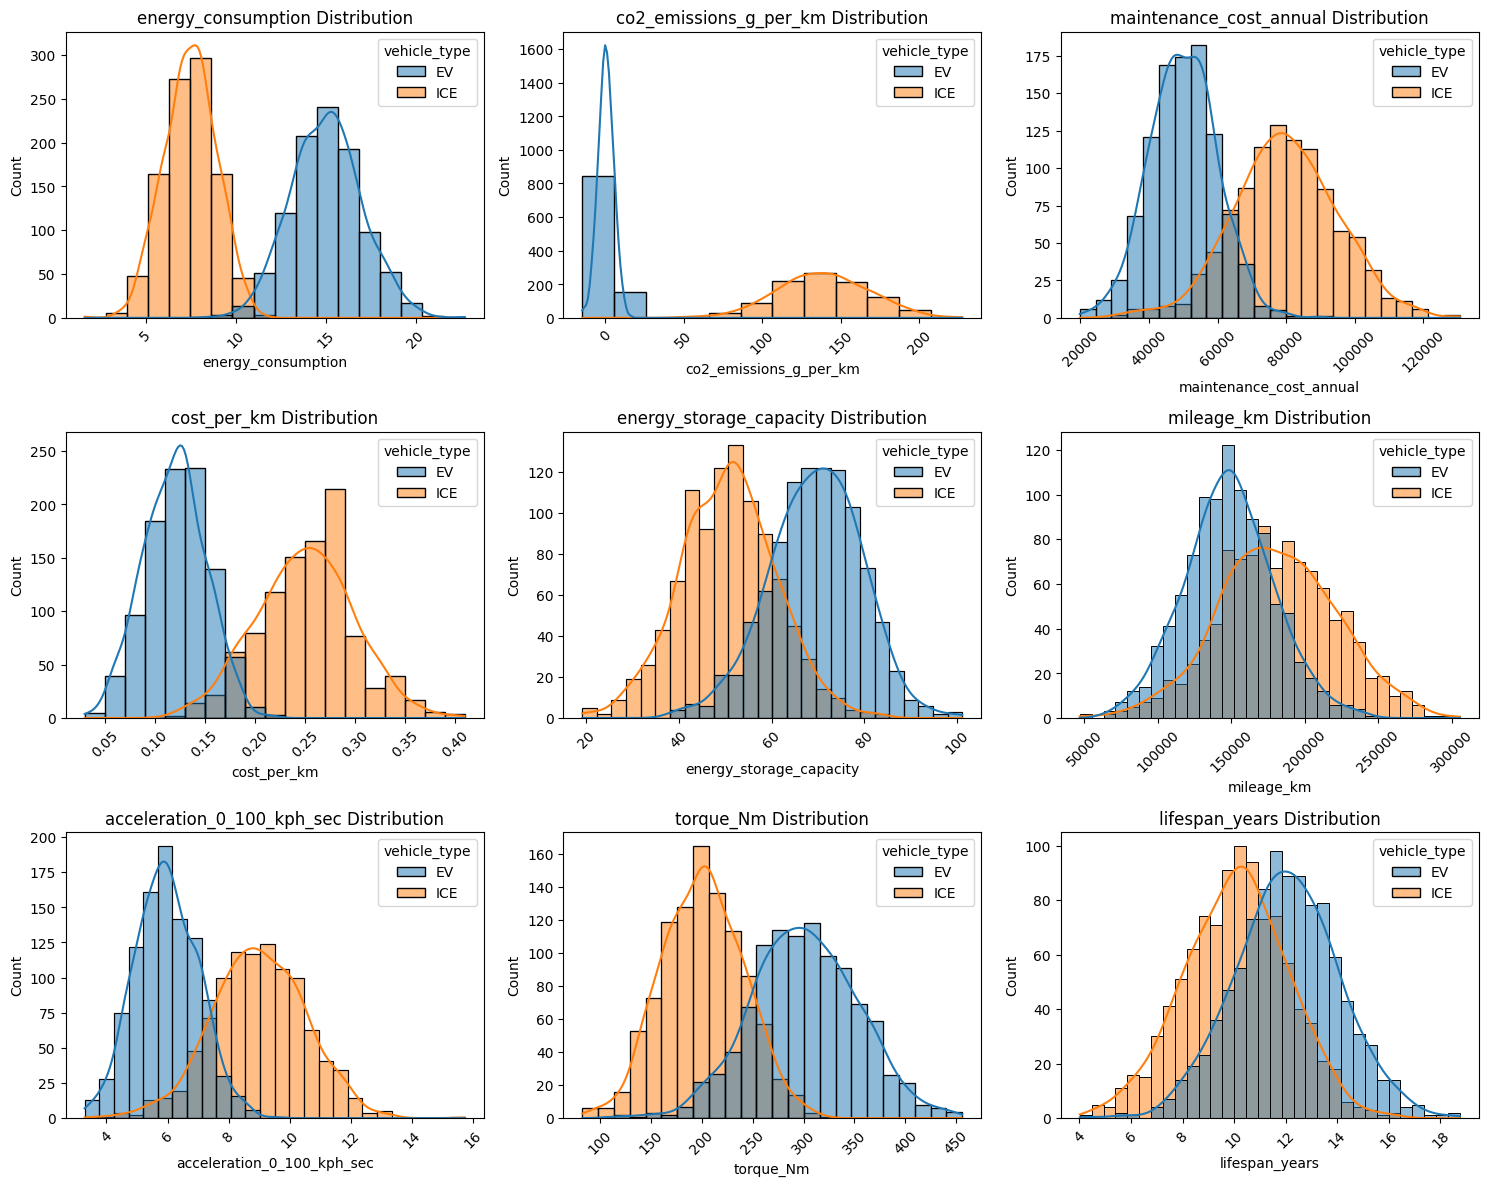

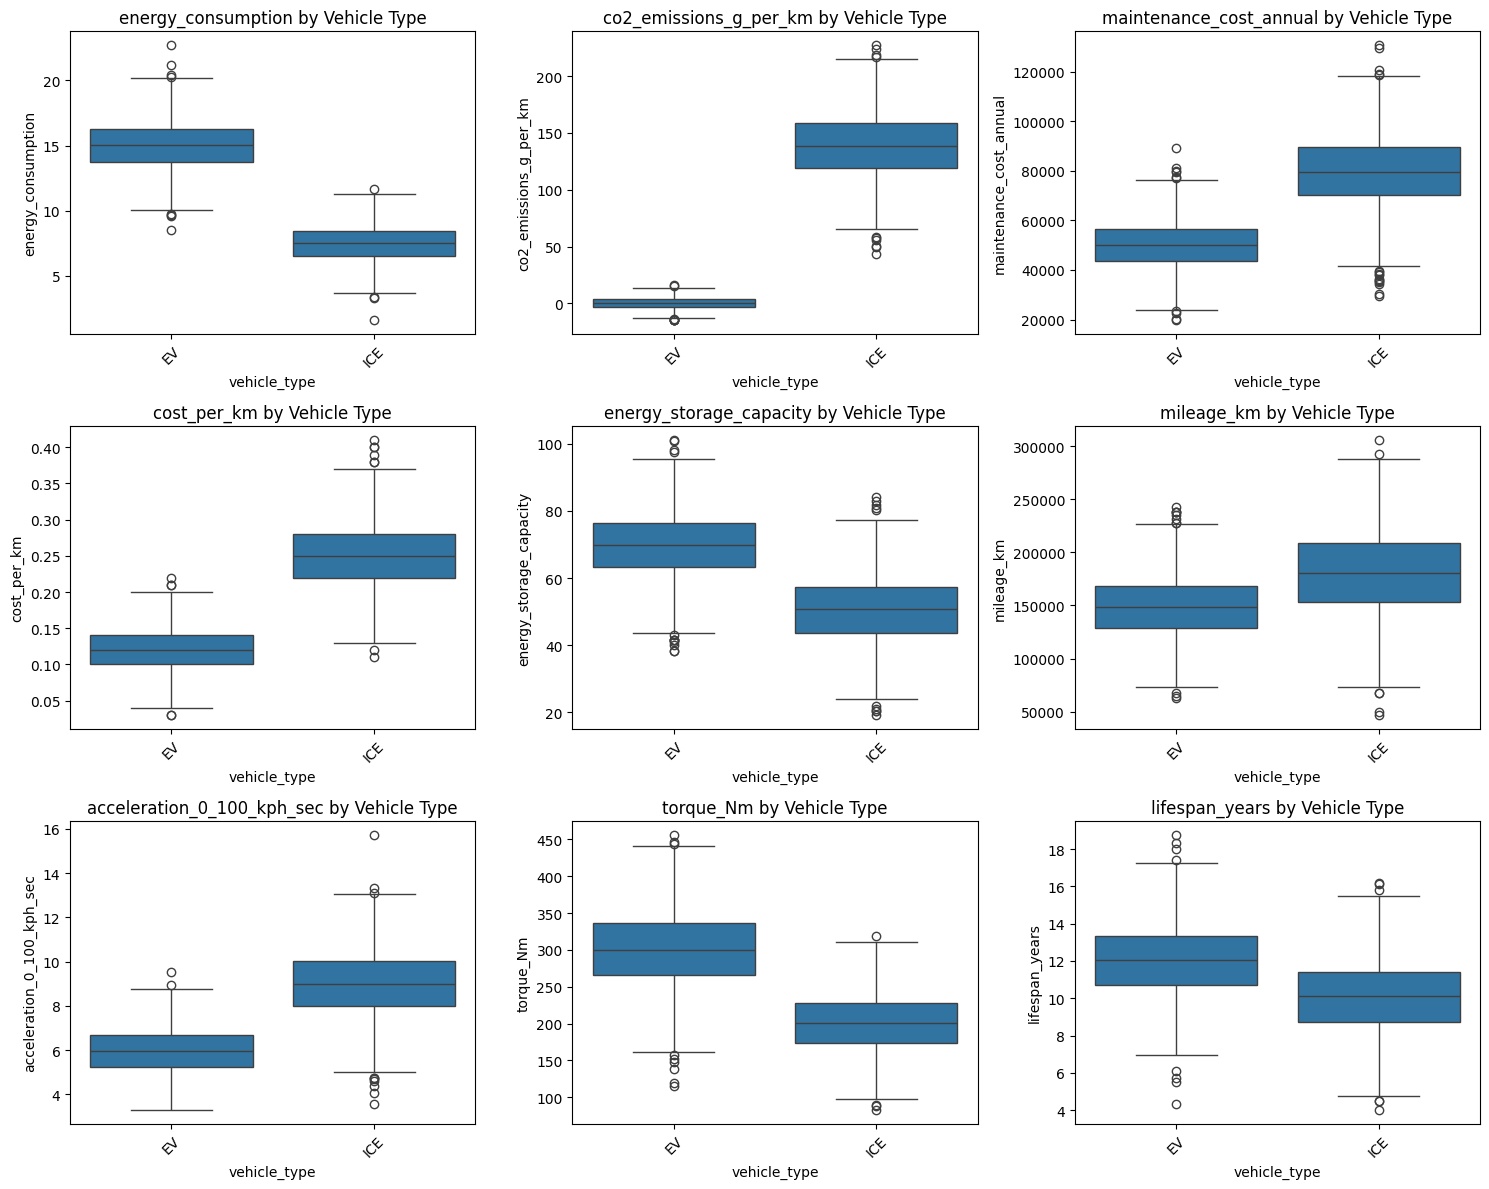

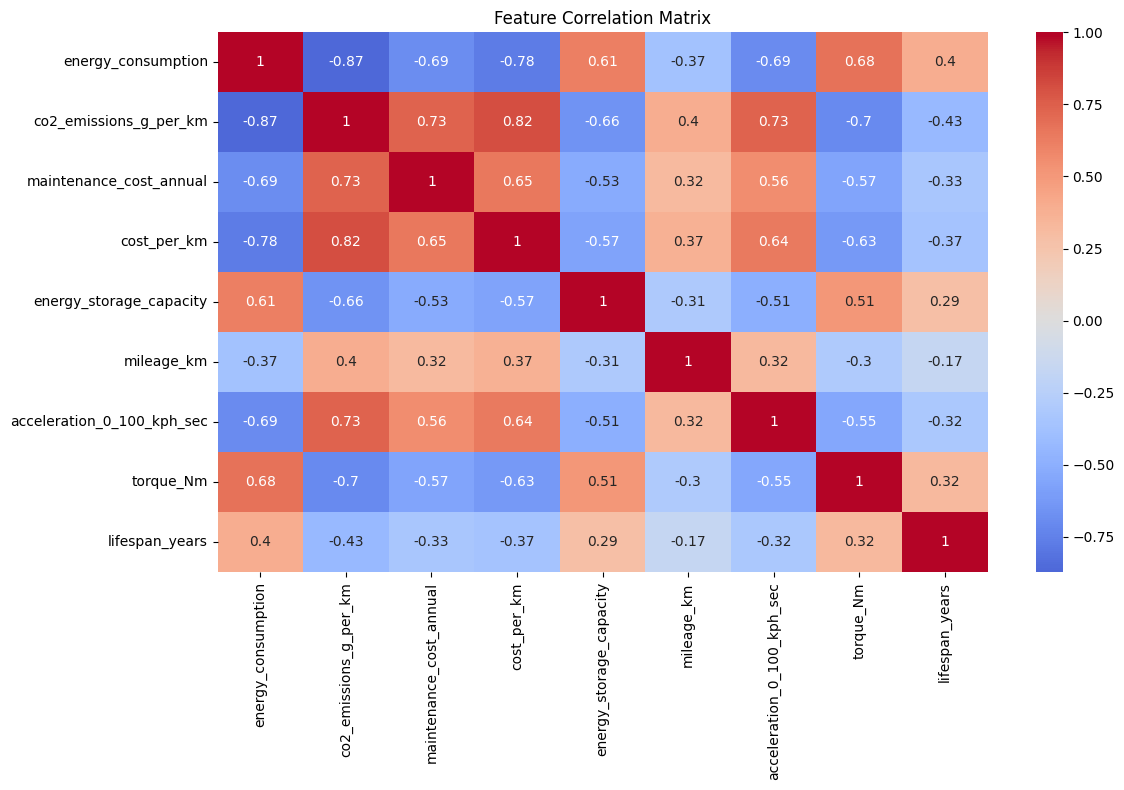

In [35]:
# Plot distributions of numeric features
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

for idx, col in enumerate(numeric_cols):
    sns.histplot(data=df, x=col, hue='vehicle_type', ax=axes[idx], kde=True)
    axes[idx].set_title(f'{col} Distribution')
    axes[idx].tick_params(axis='x', rotation=45)

# Remove any empty subplots
for idx in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

# Plot boxplots for numeric features
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

for idx, col in enumerate(numeric_cols):
    sns.boxplot(data=df, x='vehicle_type', y=col, ax=axes[idx])
    axes[idx].set_title(f'{col} by Vehicle Type')
    axes[idx].tick_params(axis='x', rotation=45)

# Remove any empty subplots
for idx in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

# Plot correlation heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   vehicle_type                2000 non-null   object 
 1   energy_consumption          2000 non-null   float64
 2   co2_emissions_g_per_km      2000 non-null   float64
 3   maintenance_cost_annual     2000 non-null   float64
 4   cost_per_km                 2000 non-null   float64
 5   energy_storage_capacity     2000 non-null   float64
 6   mileage_km                  2000 non-null   float64
 7   acceleration_0_100_kph_sec  2000 non-null   float64
 8   torque_Nm                   2000 non-null   float64
 9   lifespan_years              2000 non-null   float64
dtypes: float64(9), object(1)
memory usage: 156.4+ KB


In [37]:
df.describe()

,energy_consumption,co2_emissions_g_per_km,maintenance_cost_annual,cost_per_km,energy_storage_capacity,mileage_km,acceleration_0_100_kph_sec,torque_Nm,lifespan_years
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,11.260295,69.578445,64945.216810,0.184990,60.073365,164922.296305,7.480530,251.074575,11.050385
std,4.152934,72.321330,19643.006014,0.077222,13.813774,39175.293397,1.994707,68.071385,2.244392
min,1.620000,-14.700000,19804.880000,0.030000,19.170000,46819.850000,3.290000,82.650000,4.010000
25%,7.507500,0.317500,49379.492500,0.120000,50.180000,138746.557500,5.870000,199.642500,9.580000
50%,10.590000,29.495000,62019.815000,0.170000,60.250000,161783.215000,7.210000,246.065000,11.050000
75%,15.050000,138.257500,79653.160000,0.250000,70.462500,189842.460000,8.990000,300.595000,12.560000
max,22.710000,227.420000,130666.520000,0.410000,101.130000,305616.920000,15.720000,455.880000,18.750000


## Utils

In [52]:
def build_efficiency_index(df: pd.DataFrame) -> pd.Series:
    """Compute the efficiency index as mileage per unit of energy consumption."""

    # Ensure required columns exist
    required_cols = ["mileage_km", "energy_consumption"]
    missing = [c for c in required_cols if c not in df.columns]
    if missing:
        raise KeyError(f"Missing columns needed for efficiency index: {missing}")

    # Calculate efficiency index as mileage per unit of energy
    efficiency_index = df["mileage_km"] / df["energy_consumption"]

    return efficiency_index


def make_preprocessor(num_cols, cat_cols):
    numeric_tf = Pipeline([("scaler", StandardScaler())])
    categoric_tf = Pipeline([("ohe", OneHotEncoder(drop="first"))])

    return ColumnTransformer([
        ("num", numeric_tf, num_cols),
        ("cat", categoric_tf, cat_cols),
    ])


def plot_predictions_vs_actual(y_true, y_pred, model_name, dataset_type="Training"):
    """Plot predictions vs actual values for a model."""
    plt.figure(figsize=(8, 5))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'{model_name} - {dataset_type} Set Predictions vs Actual Values')
    
    # Add metrics to plot
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    metrics_text = f'RMSE: {rmse:.2f}\nMAE: {mae:.2f}\nR²: {r2:.2f}'
    plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

def plot_feature_importance(model, feature_names, model_name):
    """Plot feature importance for a model if available."""
    if hasattr(model, 'feature_importances_'):
        plt.figure(figsize=(8, 5))
        importances = model.feature_importances_
        fi_df = pd.Series(importances, index=feature_names).sort_values(ascending=True)
        fi_df.plot(kind='barh')
        plt.title(f'{model_name} - Feature Importances')
        plt.tight_layout()
        plt.show()
    elif hasattr(model, 'coef_'):
        plt.figure(figsize=(8, 5))
        coef = model.coef_
        if coef.ndim > 1:
            coef = coef.ravel()
        fi_df = pd.Series(coef, index=feature_names).sort_values(ascending=True)
        fi_df.plot(kind='barh')
        plt.title(f'{model_name} - Feature Coefficients')
        plt.tight_layout()
        plt.show()

def evaluate_model_with_plots(name: str, model, X, y, cv, num_cols=None, cat_cols=None, test_size=0.2, random_state=42):
    """Evaluate model performance and generate visualizations with multiple metrics."""
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    # Cross-validation scoring on training set
    cv_metrics = {
        'rmse': make_scorer(root_mean_squared_error, greater_is_better=False),
        'mae': make_scorer(mean_absolute_error, greater_is_better=False),
        'r2': make_scorer(r2_score, greater_is_better=True)
    }
    
    cv_scores = {}
    for metric_name, scorer in cv_metrics.items():
        scores = cross_val_score(model, X_train, y_train, scoring=scorer, cv=cv, n_jobs=-1)
        if metric_name in ['rmse', 'mae']:
            scores = -scores  # Convert back to positive values
        cv_scores[metric_name] = {
            'mean': scores.mean(),
            'std': scores.std()
        }
    
    print(f"\nCross-validation scores for {name}:")
    for metric, scores in cv_scores.items():
        print(f"{metric.upper()}: {scores['mean']:.3f} ± {scores['std']:.3f}")
    
    # Fit model on training set
    model.fit(X_train, y_train)
    
    # Get predictions for both training and test sets
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate test set metrics
    test_metrics = {
        'rmse': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'mae': mean_absolute_error(y_test, y_test_pred),
        'r2': r2_score(y_test, y_test_pred)
    }
    
    print(f"\nTest set metrics for {name}:")
    for metric, value in test_metrics.items():
        print(f"{metric.upper()}: {value:.3f}")
    
    # Plot predictions vs actual for both training and test sets
    plot_predictions_vs_actual(y_train, y_train_pred, name, "Training")
    plot_predictions_vs_actual(y_test, y_test_pred, name, "Test")
    
    # Get feature names and plot feature importance
    if hasattr(model, 'named_steps'):
        feature_names = (
            model.named_steps['prep'].named_transformers_['num'].get_feature_names_out(num_cols).tolist()
            + model.named_steps['prep'].named_transformers_['cat']
            .named_steps['ohe']
            .get_feature_names_out(cat_cols)
            .tolist()
        )
        plot_feature_importance(model.named_steps['model'], feature_names, name)
    else:
        feature_names = X.columns.tolist()
        plot_feature_importance(model, feature_names, name)
    
    return {
        "model": name,
        "cv_scores": cv_scores,
        "test_metrics": test_metrics
    } 

## Modeling

In [53]:
# Basic cleaning example – clamp negative CO2 to zero
df["co2_emissions_g_per_km"] = df["co2_emissions_g_per_km"].clip(lower=0)

In [54]:
df.describe()

,energy_consumption,co2_emissions_g_per_km,maintenance_cost_annual,cost_per_km,energy_storage_capacity,mileage_km,acceleration_0_100_kph_sec,torque_Nm,lifespan_years,efficiency_rating
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,11.260295,70.479485,64945.216810,0.184990,60.073365,164922.296305,7.480530,251.074575,11.050385,17643.360726
std,4.152934,71.403849,19643.006014,0.077222,13.813774,39175.293397,1.994707,68.071385,2.244392,9621.845118
min,1.620000,0.000000,19804.880000,0.030000,19.170000,46819.850000,3.290000,82.650000,4.010000,3821.381443
25%,7.507500,0.317500,49379.492500,0.120000,50.180000,138746.557500,5.870000,199.642500,9.580000,9961.115011
50%,10.590000,29.495000,62019.815000,0.170000,60.250000,161783.215000,7.210000,246.065000,11.050000,14370.785431
75%,15.050000,138.257500,79653.160000,0.250000,70.462500,189842.460000,8.990000,300.595000,12.560000,24135.421250
max,22.710000,227.420000,130666.520000,0.410000,101.130000,305616.920000,15.720000,455.880000,18.750000,101205.598765


In [55]:
build_efficiency_index(df)

0       10005.818841
1       15264.319641
2        7000.921155
3        9889.889781
4       11697.077491
            ...     
1995    13287.889265
1996    27795.096012
1997    12644.451943
1998    11969.885432
1999     8869.686308
Length: 2000, dtype: float64

In [56]:
# Build target
df["efficiency_rating"] = build_efficiency_index(df)

In [57]:
df.head()

,vehicle_type,energy_consumption,co2_emissions_g_per_km,maintenance_cost_annual,cost_per_km,energy_storage_capacity,mileage_km,acceleration_0_100_kph_sec,torque_Nm,lifespan_years,efficiency_rating
0,EV,13.80,2.68,51768.21,0.14,80.72,138080.30,5.19,328.70,14.33,10005.818841
1,EV,15.58,6.33,44111.33,0.15,48.22,237818.10,6.09,255.42,11.31,15264.319641
2,EV,18.01,3.63,48772.91,0.14,67.79,126086.59,4.60,311.03,10.64,7000.921155
3,EV,13.70,0.00,39148.49,0.10,67.86,135491.49,7.07,266.63,9.26,9889.889781
4,EV,10.84,0.00,46485.86,0.13,79.55,126796.32,7.46,263.66,14.83,11697.077491


In [58]:
# Feature lists
num_cols = [
    "co2_emissions_g_per_km",
    "maintenance_cost_annual",
    "cost_per_km",
    "energy_storage_capacity",
    "acceleration_0_100_kph_sec",
    "torque_Nm",
    "lifespan_years",
]
cat_cols = ["vehicle_type"]

X = df[num_cols + cat_cols]
y = df["efficiency_rating"]

In [59]:
X.shape

(2000, 8)

In [60]:
# Stratify on vehicle_type to keep EV/ICE ratio consistent across folds
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [61]:
# Create base pipelines
preprocessor = make_preprocessor(num_cols, cat_cols)

MODELS = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
}

# Add optional models that were successfully imported
MODELS.update(OPTIONAL_MODELS)

In [62]:
MODELS

{'Linear Regression': LinearRegression(),
 'Decision Tree': DecisionTreeRegressor(random_state=42),
 'Random Forest': RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42),
 'Gradient Boosting': GradientBoostingRegressor(random_state=42),
 'CatBoost': <catboost.core.CatBoostRegressor at 0x163151d90>,
 'LightGBM': LGBMRegressor(random_state=42),
 'XGBoost': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,


Cross-validation scores for Linear Regression:
RMSE: 5993.962 ± 567.086
MAE: 4088.065 ± 276.078
R2: 0.614 ± 0.044

Test set metrics for Linear Regression:
RMSE: 5626.906
MAE: 3903.243
R2: 0.638


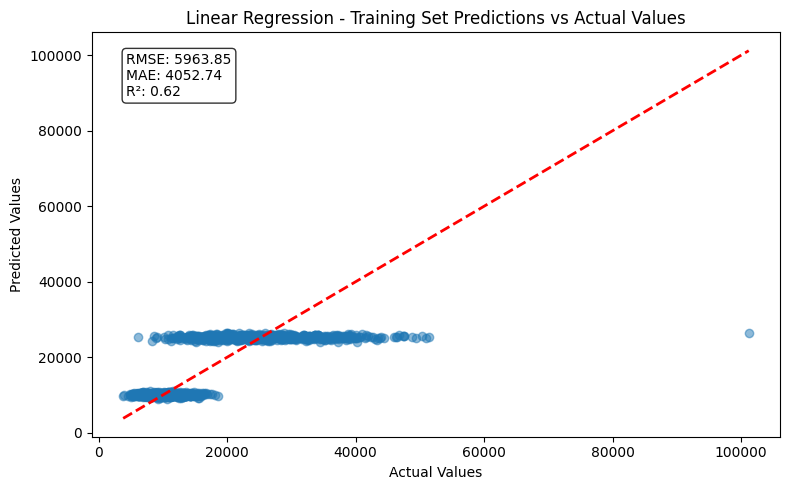

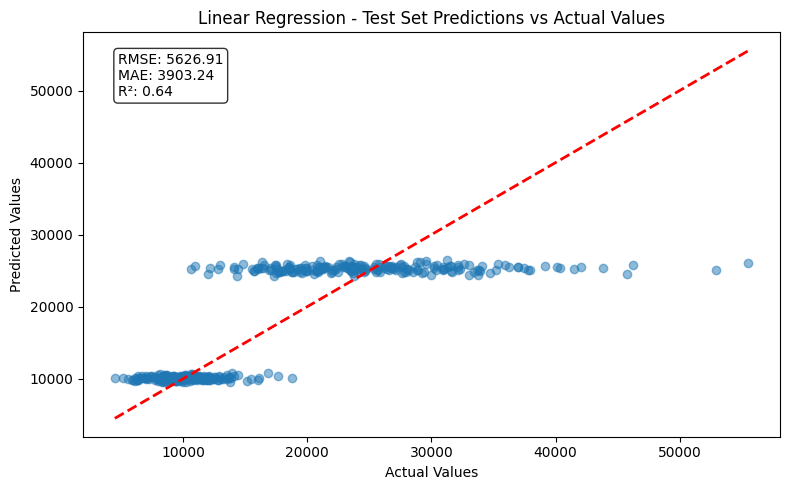

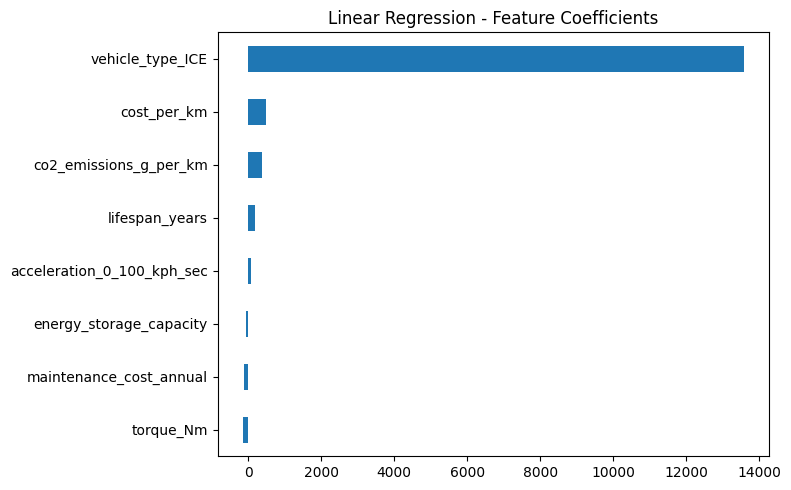

Linear Regression    | RMSE = 5993.96 ± 567.09

Cross-validation scores for Decision Tree:
RMSE: 8266.032 ± 524.178
MAE: 5774.099 ± 366.413
R2: 0.261 ± 0.103

Test set metrics for Decision Tree:
RMSE: 8192.767
MAE: 5596.267
R2: 0.233


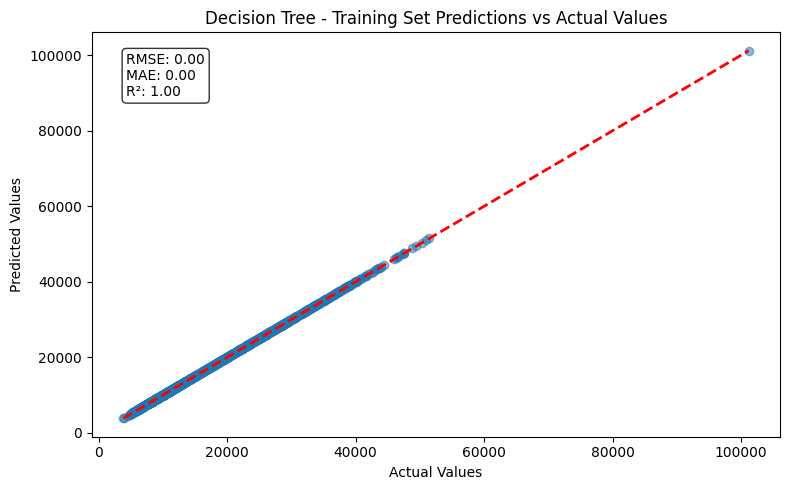

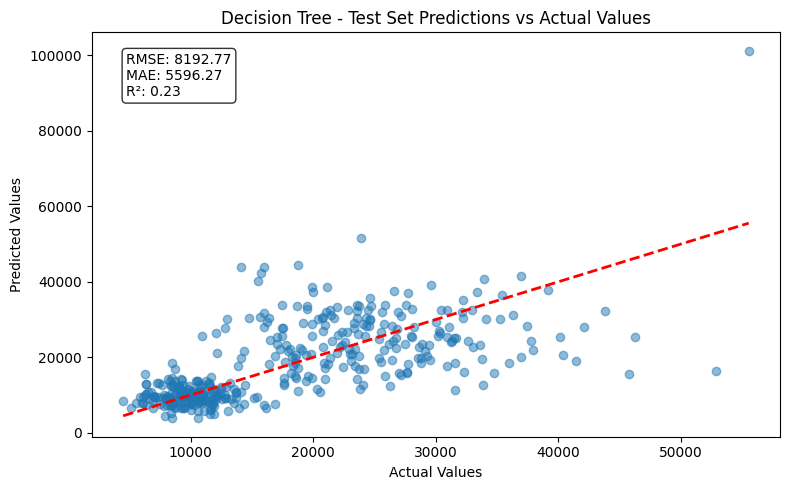

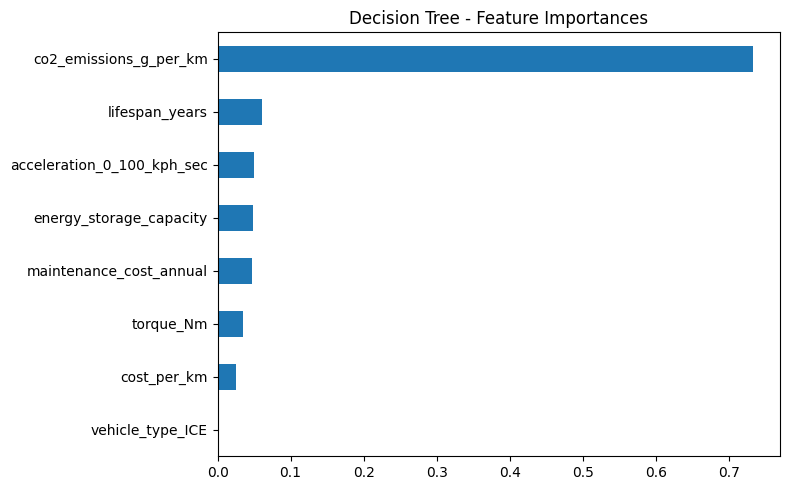

Decision Tree        | RMSE = 8266.03 ± 524.18

Cross-validation scores for Random Forest:
RMSE: 6105.406 ± 525.108
MAE: 4189.615 ± 247.429
R2: 0.600 ± 0.039

Test set metrics for Random Forest:
RMSE: 5657.259
MAE: 4050.870
R2: 0.634


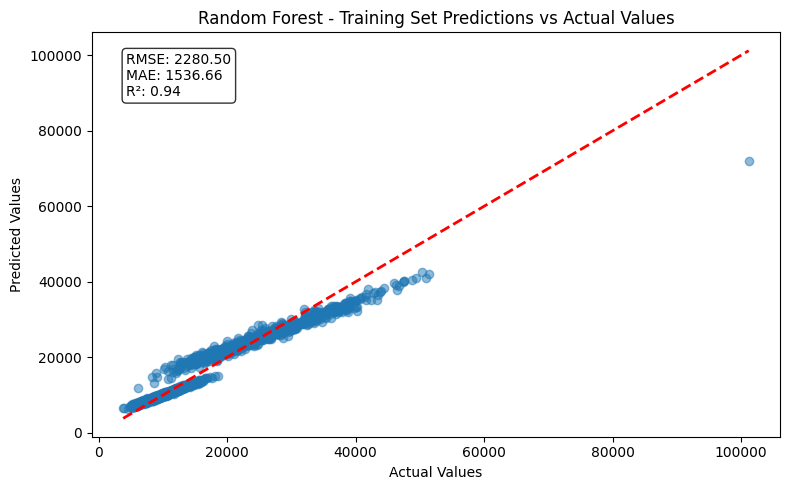

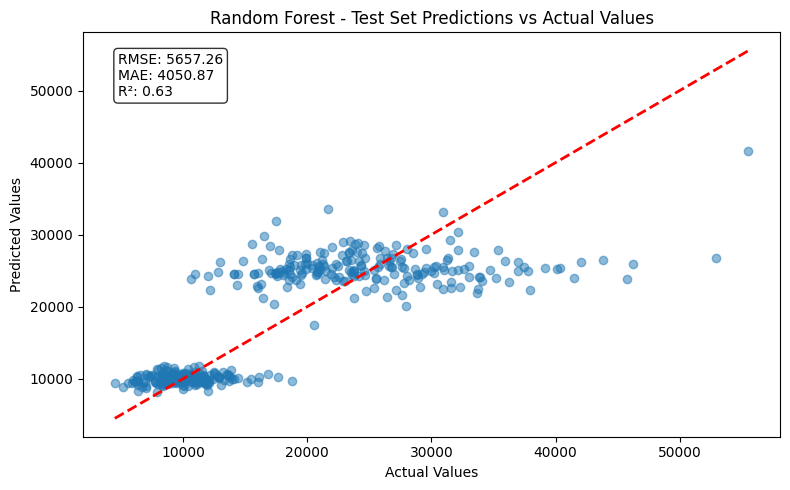

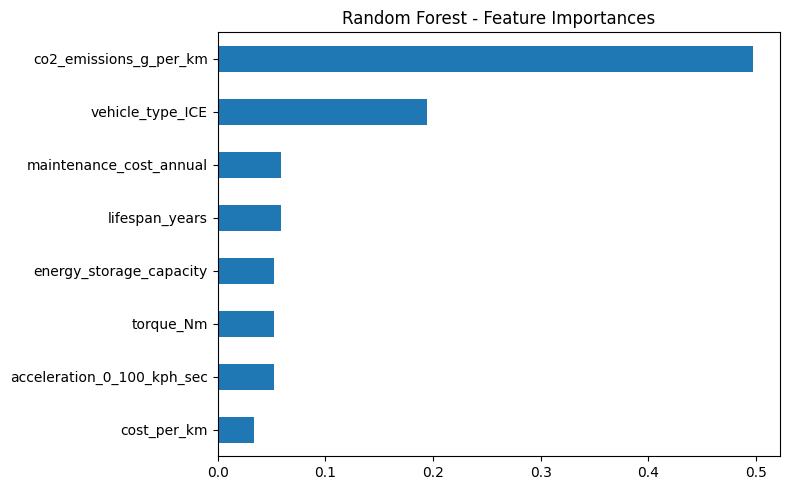

Random Forest        | RMSE = 6105.41 ± 525.11

Cross-validation scores for Gradient Boosting:
RMSE: 6150.206 ± 498.116
MAE: 4152.708 ± 226.013
R2: 0.594 ± 0.038

Test set metrics for Gradient Boosting:
RMSE: 5632.559
MAE: 3977.799
R2: 0.637


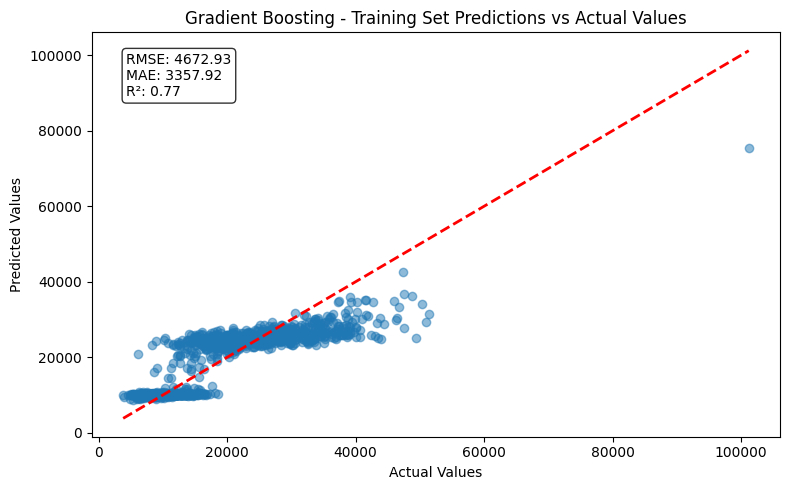

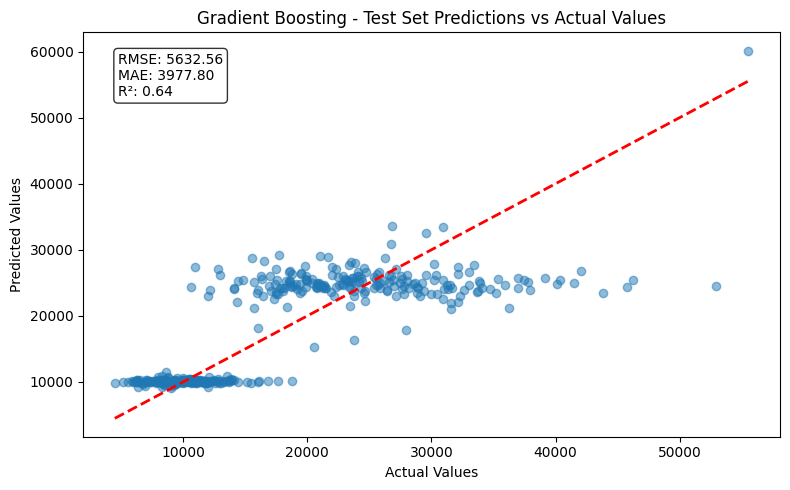

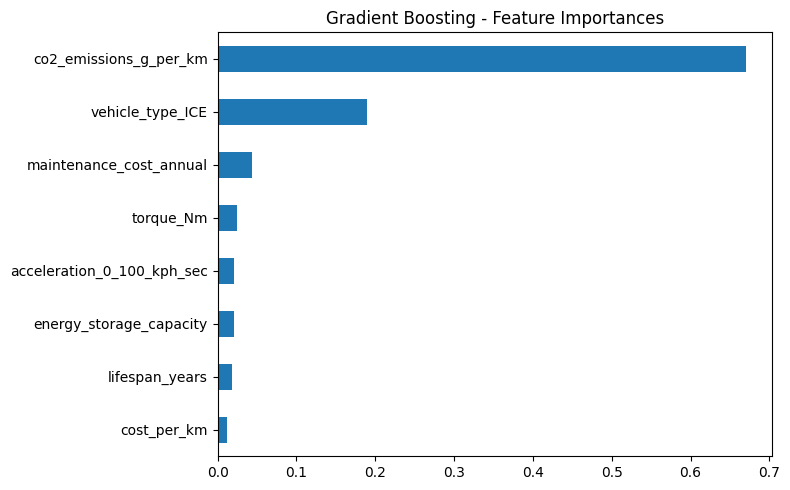

Gradient Boosting    | RMSE = 6150.21 ± 498.12

Cross-validation scores for CatBoost:
RMSE: 6295.277 ± 428.095
MAE: 4292.737 ± 232.011
R2: 0.575 ± 0.032

Test set metrics for CatBoost:
RMSE: 5949.834
MAE: 4184.887
R2: 0.595


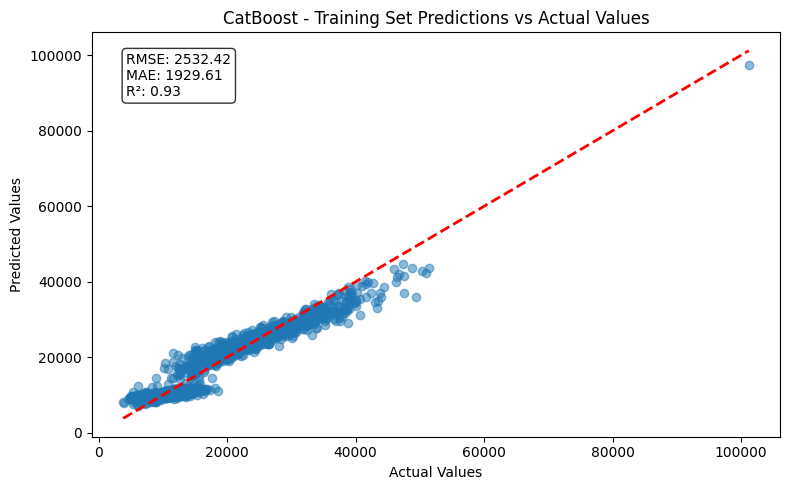

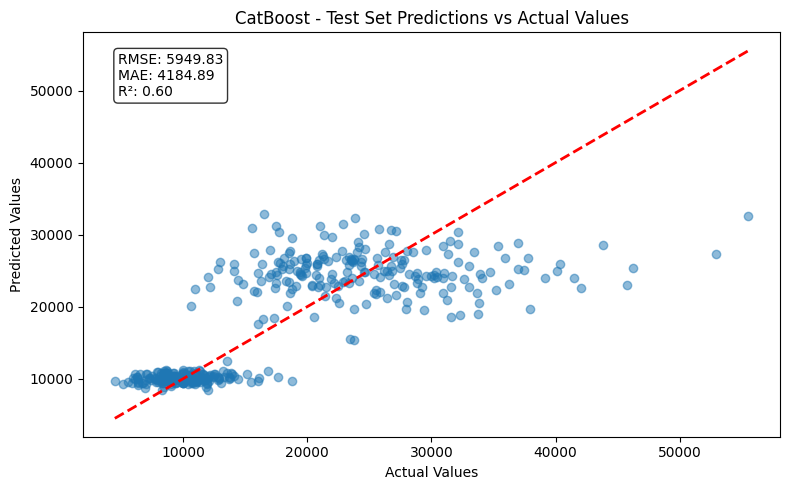

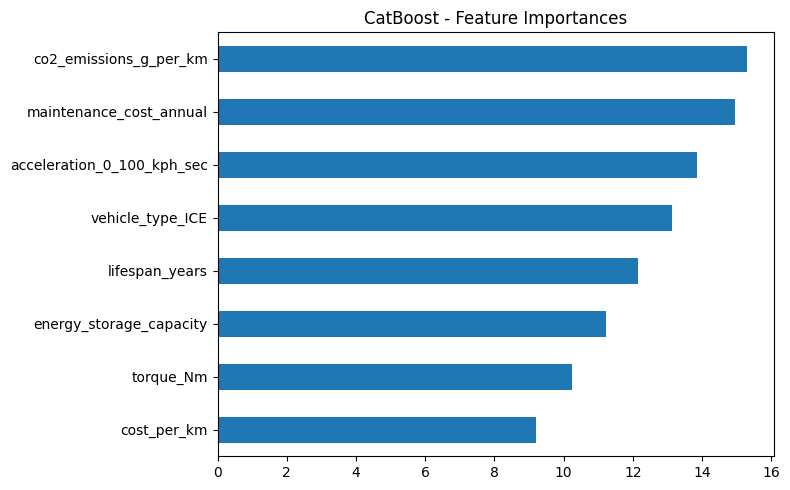

CatBoost             | RMSE = 6295.28 ± 428.09
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1569
[LightGBM] [Info] Number of data points in the train set: 1280, number of used features: 8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Start training from score 17674.269865
[LightGBM] [Info] Total Bins 1568
[LightGBM] [Info] Number of data points in the train set: 1280, number of used features: 8
[LightGBM] [Info] Start training from score 17335.405902
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1568
[LightGBM] [Info] Number of data points in the train set: 1280, numbe

/opt/anaconda3/envs/betzflip-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/betzflip-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/betzflip-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/betzflip-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/betzflip-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRe

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000590 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1569
[LightGBM] [Info] Number of data points in the train set: 1280, number of used features: 8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000906 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Start training from score 17674.269865
[LightGBM] [Info] Total Bins 1568
[LightGBM] [Info] Number of data points in the train set: 1280, number of used features: 8
[LightGBM] [Info] Start training from score 17335.405902
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1568
[LightGBM] [Info] Number of data points in the train set: 1280, number of used features: 8
[LightGBM] [Info] Start t

/opt/anaconda3/envs/betzflip-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/betzflip-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/betzflip-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/betzflip-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/betzflip-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRe

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000372 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1569
[LightGBM] [Info] Number of data points in the train set: 1280, number of used features: 8
[LightGBM] [Info] Start training from score 17674.269865
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1568
[LightGBM] [Info] Number of data points in the train set: 1280, number of used features: 8
[LightGBM] [Info] Start training from score 17335.405902
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1568
[LightGBM] [Info] Number of data points in the train set: 1280, number of used features: 8
[LightGBM] [Info] Start t

/opt/anaconda3/envs/betzflip-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/betzflip-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/betzflip-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/betzflip-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/betzflip-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRe


Cross-validation scores for LightGBM:
RMSE: 6563.870 ± 426.390
MAE: 4473.204 ± 231.556
R2: 0.538 ± 0.027
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1569
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 8
[LightGBM] [Info] Start training from score 17597.681686


/opt/anaconda3/envs/betzflip-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/envs/betzflip-env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



Test set metrics for LightGBM:
RMSE: 6149.522
MAE: 4302.856
R2: 0.568


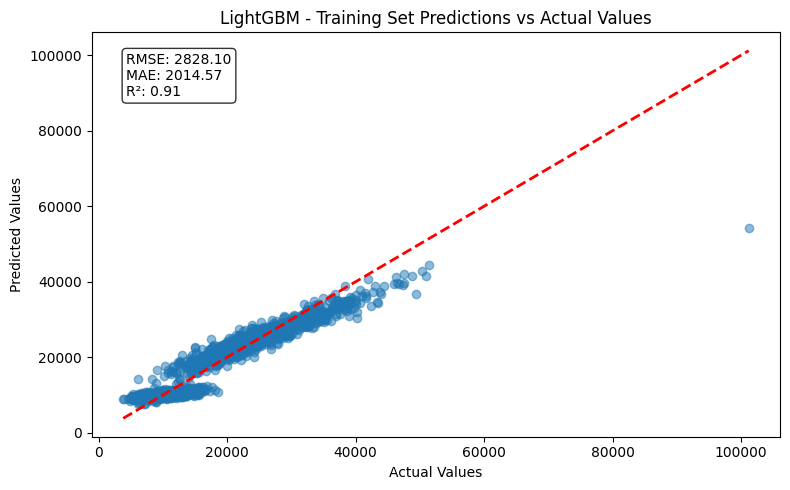

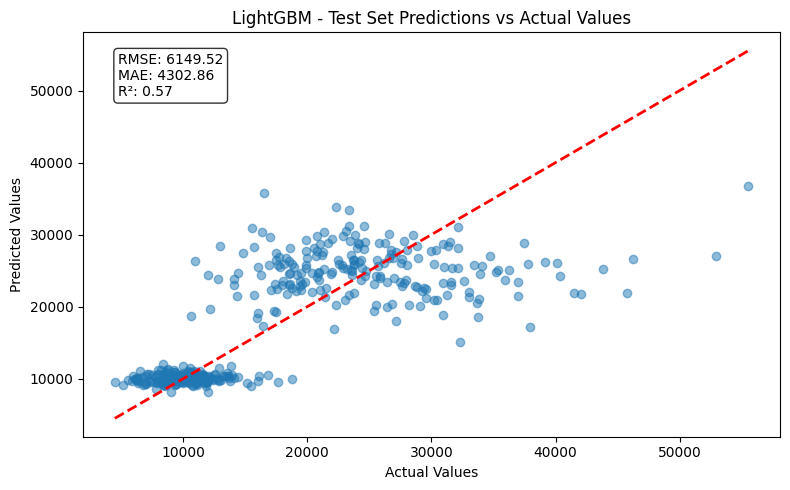

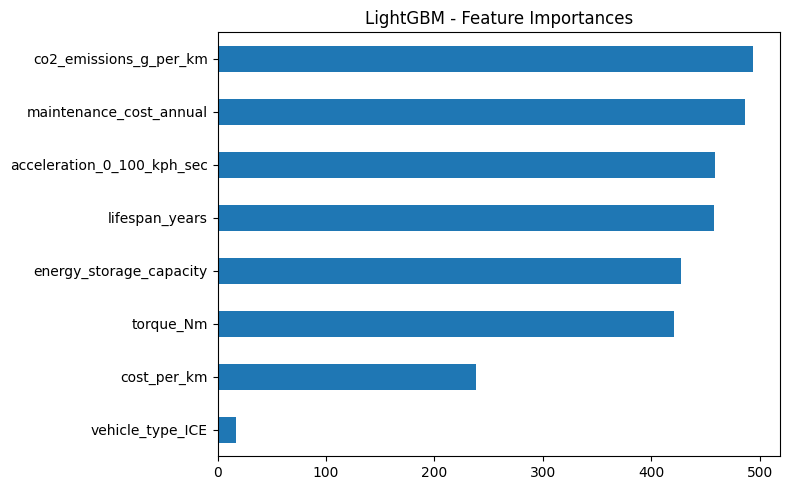

LightGBM             | RMSE = 6563.87 ± 426.39

Cross-validation scores for XGBoost:
RMSE: 6673.383 ± 324.833
MAE: 4543.549 ± 201.706
R2: 0.521 ± 0.034

Test set metrics for XGBoost:
RMSE: 6138.975
MAE: 4368.904
R2: 0.569


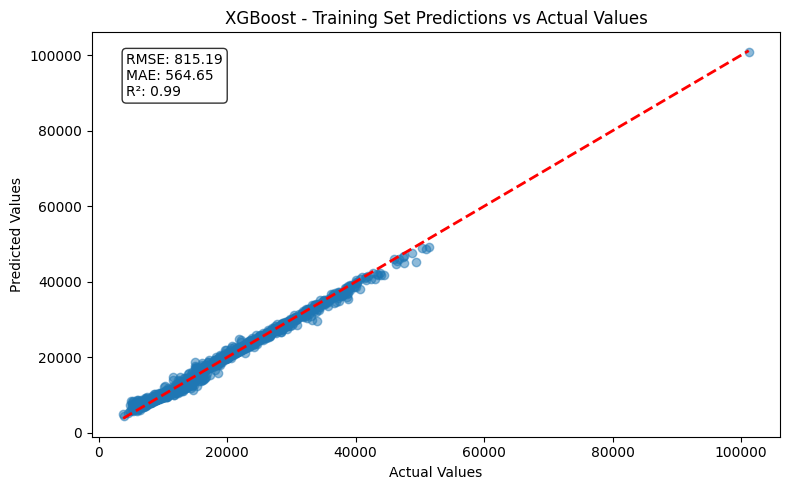

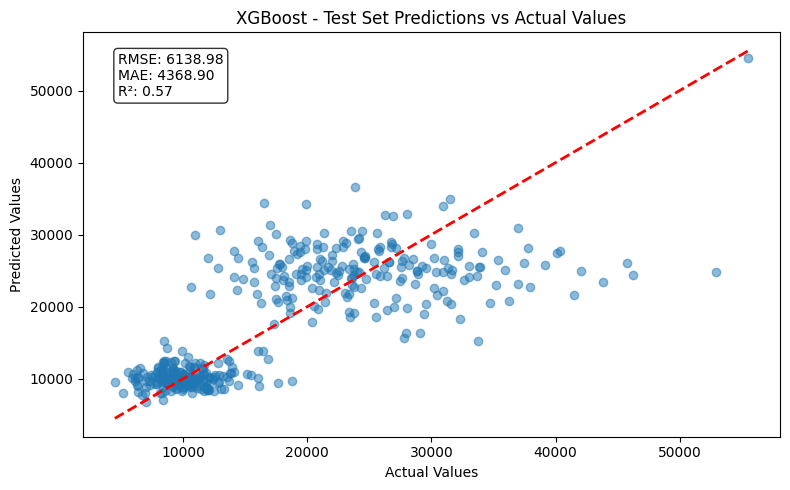

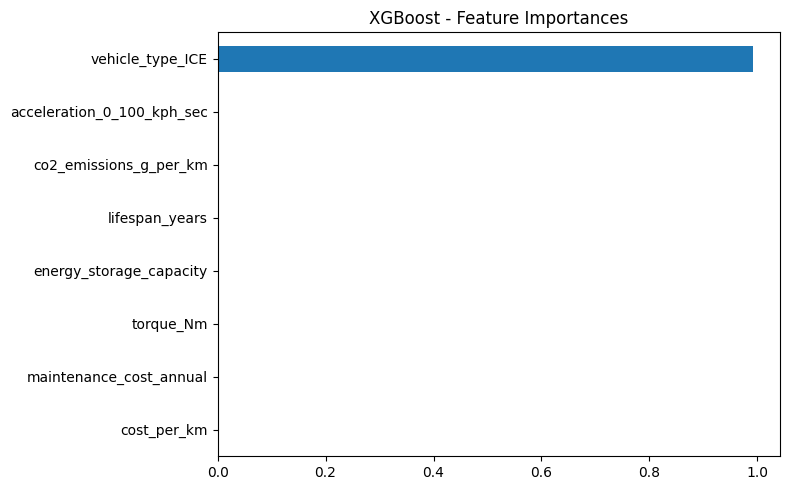

XGBoost              | RMSE = 6673.38 ± 324.83


In [64]:
results = []
best_name = None
best_score = np.inf
best_estimator = None

for name, reg in MODELS.items():
    pipe = Pipeline([
        ("prep", preprocessor),
        ("model", reg),
    ])
    res = evaluate_model_with_plots(name, pipe, X, y, cv, num_cols=num_cols, cat_cols=cat_cols)
    results.append(res)
    print(f"{name:<20} | RMSE = {res['cv_scores']['rmse']['mean']:.2f} ± {res['cv_scores']['rmse']['std']:.2f}")

    if res['cv_scores']['rmse']['mean'] < best_score:
        best_score = res['cv_scores']['rmse']['mean']
        best_name = name
        best_estimator = pipe

In [65]:
# Create DataFrame from results and flatten nested dictionary structure
results_df = pd.DataFrame([
    {
        'model': r['model'],
        'rmse_mean': r['cv_scores']['rmse']['mean'],
        'rmse_std': r['cv_scores']['rmse']['std'],
        'mae_mean': r['cv_scores']['mae']['mean'],
        'mae_std': r['cv_scores']['mae']['std'],
        'r2_mean': r['cv_scores']['r2']['mean'],
        'r2_std': r['cv_scores']['r2']['std'],
        'test_rmse': r['test_metrics']['rmse'],
        'test_mae': r['test_metrics']['mae'],
        'test_r2': r['test_metrics']['r2']
    }
    for r in results
]).sort_values('rmse_mean')

# Create output directory
output_dir = Path("output")
output_dir.mkdir(parents=True, exist_ok=True)

# Save results to CSV
results_path = output_dir / "model_comparison_results.csv"
results_df.to_csv(results_path, index=False)
print("\nModel comparison results saved to", results_path)

# Save best model if available
if best_estimator is not None and best_name is not None:
    # Fit final model on full dataset
    best_estimator.fit(X, y)
    
    # Save model
    best_path = output_dir / f"best_model_{best_name.replace(' ', '_').lower()}.joblib"
    dump(best_estimator, best_path)
    print(f"\nBest model ({best_name}) saved to {best_path}")
    
    # Save feature importances if available
    if hasattr(best_estimator[-1], "feature_importances_"):
        # Get feature names from preprocessor
        feature_names = (
            best_estimator["prep"].named_transformers_["num"].get_feature_names_out(num_cols).tolist()
            + best_estimator["prep"].named_transformers_["cat"]
            .named_steps["ohe"]
            .get_feature_names_out(cat_cols)
            .tolist()
        )
        
        # Create and save feature importances
        importances = best_estimator[-1].feature_importances_
        fi = pd.Series(importances, index=feature_names).sort_values(ascending=False)
        fi_path = output_dir / "feature_importances.json"
        fi.to_json(fi_path, orient="records")
        print("Feature importances saved to", fi_path)


Model comparison results saved to output/model_comparison_results.csv

Best model (Linear Regression) saved to output/best_model_linear_regression.joblib


## Model Finetuning 

Starting XGBoost hyperparameter tuning on training set...
Fitting 5 folds for each of 729 candidates, totalling 3645 fits
[CV] END model__colsample_bytree=0.6, model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=1, model__n_estimators=100, model__subsample=0.6; total time=   0.1s
[CV] END model__colsample_bytree=0.6, model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=1, model__n_estimators=100, model__subsample=0.6; total time=   0.1s
[CV] END model__colsample_bytree=0.6, model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=1, model__n_estimators=100, model__subsample=0.6; total time=   0.1s
[CV] END model__colsample_bytree=0.6, model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=1, model__n_estimators=100, model__subsample=0.6; total time=   0.1s
[CV] END model__colsample_bytree=0.6, model__learning_rate=0.01, model__max_depth=3, model__min_child_weight=1, model__n_estimators=100, model__subsample=0.6; total t

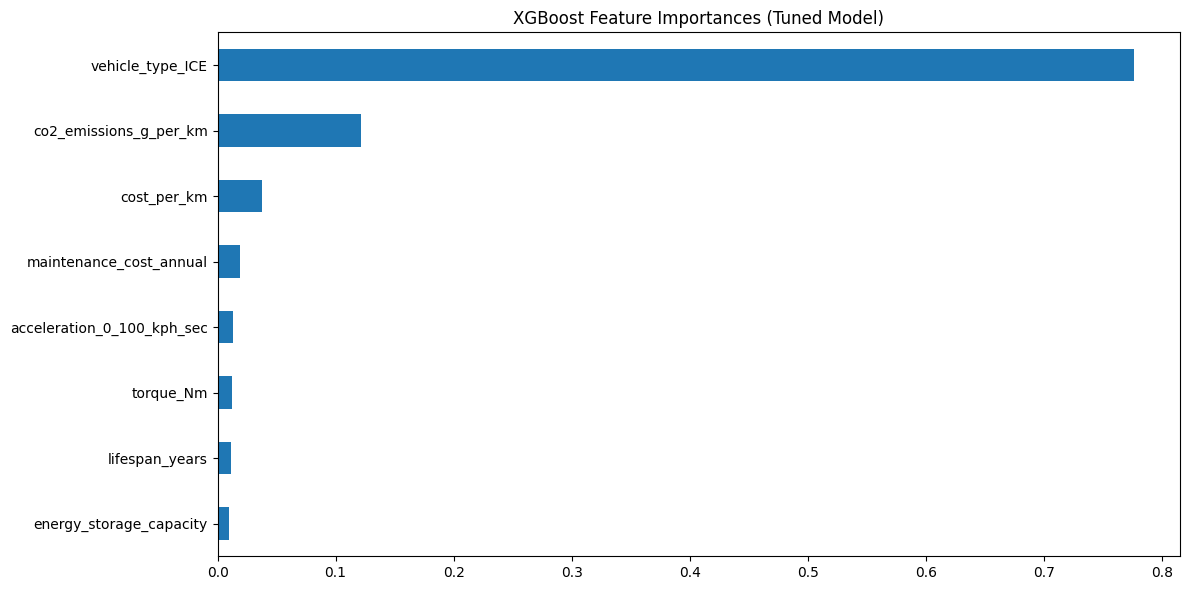

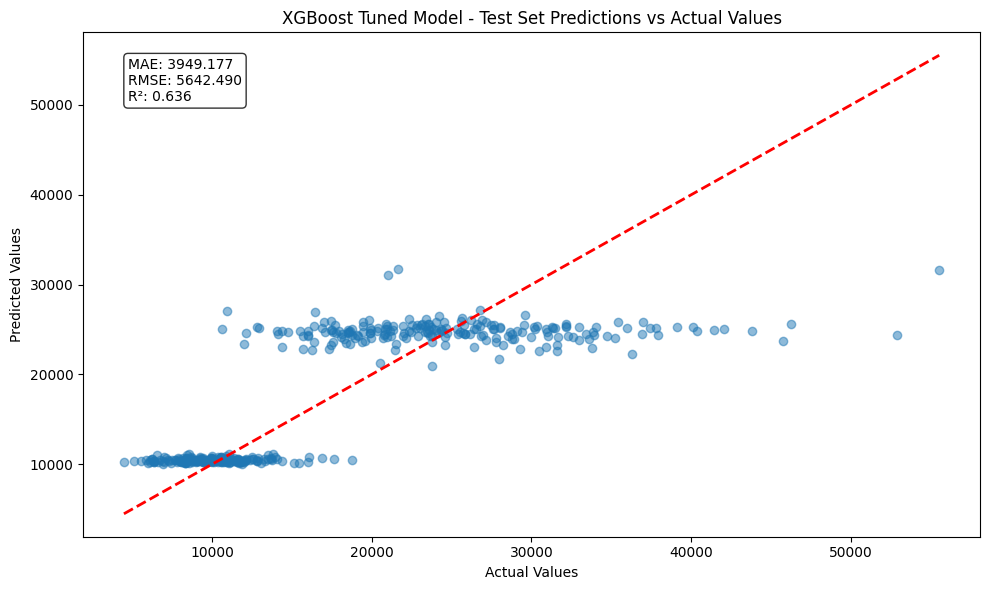


Tuned XGBoost model saved to output/tuned_xgboost_model.joblib
Model metrics saved to output/tuned_xgboost_metrics.json


In [68]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Define hyperparameter grid for XGBoost
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__min_child_weight': [1, 3, 5],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0]
}

# Create base pipeline with XGBoost
xgb_pipe = Pipeline([
    ('prep', make_preprocessor(num_cols, cat_cols)),
    ('model', XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1
    ))
])

# Setup GridSearchCV with multiple scoring metrics
scoring = {
    'neg_mae': 'neg_mean_absolute_error',
    'neg_rmse': 'neg_root_mean_squared_error',
    'r2': 'r2'
}

grid_search = GridSearchCV(
    estimator=xgb_pipe,
    param_grid=param_grid,
    cv=5,
    scoring=scoring,
    refit='neg_mae',  # Use MAE as the primary metric for model selection
    n_jobs=-1,
    verbose=2
)

# Fit the grid search on training data only
print("Starting XGBoost hyperparameter tuning on training set...")
grid_search.fit(X_train, y_train)

# Print best parameters and cross-validation scores
print("\nBest parameters:", grid_search.best_params_)
print("\nCross-validation scores for best model (on training set):")
print(f"MAE: {-grid_search.cv_results_['mean_test_neg_mae'][grid_search.best_index_]:.3f} ± {grid_search.cv_results_['std_test_neg_mae'][grid_search.best_index_]:.3f}")
print(f"RMSE: {-grid_search.cv_results_['mean_test_neg_rmse'][grid_search.best_index_]:.3f} ± {grid_search.cv_results_['std_test_neg_rmse'][grid_search.best_index_]:.3f}")
print(f"R²: {grid_search.cv_results_['mean_test_r2'][grid_search.best_index_]:.3f} ± {grid_search.cv_results_['std_test_r2'][grid_search.best_index_]:.3f}")

# Get best model and evaluate on test set
best_xgb = grid_search.best_estimator_
y_train_pred = best_xgb.predict(X_train)
y_test_pred = best_xgb.predict(X_test)

# Calculate metrics for both training and test sets
train_metrics = {
    'MAE': mean_absolute_error(y_train, y_train_pred),
    'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
    'R²': r2_score(y_train, y_train_pred)
}

test_metrics = {
    'MAE': mean_absolute_error(y_test, y_test_pred),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
    'R²': r2_score(y_test, y_test_pred)
}

print("\nTraining set metrics:")
for metric, value in train_metrics.items():
    print(f"{metric}: {value:.3f}")

print("\nTest set metrics:")
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.3f}")

# Get feature importances from best model
importances = best_xgb.named_steps['model'].feature_importances_
feature_names = (
    best_xgb.named_steps['prep'].named_transformers_['num'].get_feature_names_out(num_cols).tolist()
    + best_xgb.named_steps['prep'].named_transformers_['cat']
    .named_steps['ohe']
    .get_feature_names_out(cat_cols)
    .tolist()
)

# Plot feature importances
plt.figure(figsize=(12, 6))
fi_df = pd.Series(importances, index=feature_names).sort_values(ascending=True)
fi_df.plot(kind='barh')
plt.title('XGBoost Feature Importances (Tuned Model)')
plt.tight_layout()
plt.show()

# Plot predictions vs actual for test set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('XGBoost Tuned Model - Test Set Predictions vs Actual Values')
metrics_text = '\n'.join([f'{k}: {v:.3f}' for k, v in test_metrics.items()])
plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.tight_layout()
plt.show()

# Save tuned model and metrics
tuned_model_path = output_dir / "tuned_xgboost_model.joblib"
dump(best_xgb, tuned_model_path)
print(f"\nTuned XGBoost model saved to {tuned_model_path}")

# Save metrics to JSON
metrics_path = output_dir / "tuned_xgboost_metrics.json"
with open(metrics_path, 'w') as f:
    json.dump({
        'cv_metrics': {
            'mae': float(-grid_search.cv_results_['mean_test_neg_mae'][grid_search.best_index_]),
            'rmse': float(-grid_search.cv_results_['mean_test_neg_rmse'][grid_search.best_index_]),
            'r2': float(grid_search.cv_results_['mean_test_r2'][grid_search.best_index_])
        },
        'train_metrics': {k: float(v) for k, v in train_metrics.items()},
        'test_metrics': {k: float(v) for k, v in test_metrics.items()},
        'best_params': grid_search.best_params_
    }, f, indent=4)
print(f"Model metrics saved to {metrics_path}")
